In [98]:
# üìå Ïô∏Î∂Ä py ÌååÏùº ÏàòÏ†ï Ïãú ÏûêÎèôÏúºÎ°ú Ïû¨Î°úÎìúÎêòÎèÑÎ°ù ÏÑ§Ï†ï
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
# ================================================
# üì¶ Í≥µÌÜµ Ìå®ÌÇ§ÏßÄ import
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import sys

# src Í≤ΩÎ°ú Ï∂îÍ∞Ä
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# seaborn Ïä§ÌÉÄÏùº ÏÑ§Ï†ï
sns.set(style="whitegrid")

# ================================================
# ‚öôÔ∏è Í≤ΩÎ°ú Î∞è ÏÉÅÏàò ÏÑ§Ï†ï
# ================================================
DATA_DIR = "../data/processed"
OUTPUT_DIR = "../data/modeling"
SEOUL_STATION_PATH = os.path.join(DATA_DIR, "seoul_env_station_mapped.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# KMeans ÏÑ§Ï†ï
KMEANS_MODE = "auto" # auto, manual
KMEANS_MANUAL_K = 5

# XGBoost ÏÑ§Ï†ï
XGB_N_ESTIMATORS = 100

# MCLP ÏÑ§Ï†ï
COVERAGE_RADIUS = 0.005
FACILITY_LIMIT = 30

# ================================================
# üß™ ÌèâÍ∞Ä Ìï®Ïàò import
# ================================================
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# ================================================
# üß† Î™®Îç∏ Ìï®Ïàò import
# ================================================
from modeling.kmeans_model import run_kmeans

# K means

In [121]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")

# ÏàòÏöîÍ∞Ä Í∞ÄÏû• ÎÜíÏùÄ ÌÅ¥Îü¨Ïä§ÌÑ∞Îßå Ï∂îÏ∂ú
grid = run_kmeans(
    grid,
    mode=KMEANS_MODE,
    # manual_k=KMEANS_MANUAL_K,
    return_top_cluster_only=True
)

Finding optimal k:   0%|          | 0/9 [00:00<?, ?it/s]

Finding optimal k: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:00<00:00, 20.53it/s]

[AUTO MODE] ÏµúÏ†Å k = 2
Inertia by k: {2: 394878040.6060905, 3: 182752136.7917526, 4: 111630868.37625773, 5: 83130803.13068569, 6: 65292788.3815513, 7: 54917904.7908943, 8: 48181642.39693806, 9: 36633734.731904596, 10: 32347245.131689377}

[ClusterÎ≥Ñ ÌèâÍ∑† ÏàòÏöî]
cluster
1    1360.575095
0      57.366915
Name: demand_score, dtype: float64

[ÌïÑÌÑ∞ÎßÅ] ÏàòÏöîÍ∞Ä Í∞ÄÏû• ÎÜíÏùÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ (cluster=1)Îßå Î∞òÌôòÎê®.


In [122]:
# ÌïÑÏöîÌïú Ïª¨ÎüºÎßå Ïú†ÏßÄ (grid: KMeans Í≤∞Í≥º)
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]

# ÏõêÎ≥∏ feature Î°úÎìú
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")

# Î≥ëÌï© Ï†Ñ: features_all Ï¢åÌëú Ï†úÍ±∞ (ÌòºÎèô Î∞©ÏßÄ)
features_all = features_all.drop(columns=['center_lat', 'center_lon'], errors='ignore')

# Î≥ëÌï©
features = features_all.merge(grid, on='grid_id', how='inner')

# cluster Ï†ïÏàòÌòï Ï≤òÎ¶¨
features['cluster'] = features['cluster'].astype(int)

# Ï†ÄÏû• Ï†Ñ Ï¢åÌëú Ï†ïÎ¶¨: Ïù¥ÎØ∏ Ïù¥Î¶ÑÏù¥ Ï†ïÎèàÎèº ÏûàÏùå
# ‚Üí center_lat, center_lon Ïù¥ grid Í∏∞Ï§ÄÏúºÎ°úÎßå Ï°¥Ïû¨
features = features.loc[:, ~features.columns.duplicated()]  # ÌòπÏãú Î™®Î•º Ï§ëÎ≥µ Ï†úÍ±∞

# Ï†ÄÏû•
features.to_csv(f"{DATA_DIR}/filtered_cluster_features.csv", index=False)
print("‚úÖ Ï¢åÌëú Ïª¨Îüº Ï§ëÎ≥µ ÏóÜÏù¥ Ï†ïÎ¶¨ Î∞è Ï†ÄÏû• ÏôÑÎ£å")

# ÌôïÏù∏
print(f"Ï†ÑÏ≤¥ feature Ïàò: {len(features_all)}")
print(f"ÏàòÏöî Î∞ÄÏßë ÌÅ¥Îü¨Ïä§ÌÑ∞ feature Ïàò: {len(features)}")
print(f"Î≥ëÌï© ÌõÑ Ïú†ÏßÄÎêú ÎπÑÏú®: {len(features) / len(features_all) * 100:.2f}%")
print(f"ÏÇ¨Ïö© Í∞ÄÎä•Ìïú feature Ïª¨Îüº: {features.columns.tolist()}")

‚úÖ Ï¢åÌëú Ïª¨Îüº Ï§ëÎ≥µ ÏóÜÏù¥ Ï†ïÎ¶¨ Î∞è Ï†ÄÏû• ÏôÑÎ£å
Ï†ÑÏ≤¥ feature Ïàò: 6030
ÏàòÏöî Î∞ÄÏßë ÌÅ¥Îü¨Ïä§ÌÑ∞ feature Ïàò: 526
Î≥ëÌï© ÌõÑ Ïú†ÏßÄÎêú ÎπÑÏú®: 8.72%
ÏÇ¨Ïö© Í∞ÄÎä•Ìïú feature Ïª¨Îüº: ['grid_id', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'center_lat', 'center_lon', 'cluster']


## ÏÑúÏö∏ Ï†ÑÏ≤¥ (ÌöåÏÉâ) - ÏàòÏöî (Îπ®Í∞ÑÏÉâ)

In [ ]:
import folium
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

# Í≤ΩÎ°ú ÏÑ§Ï†ï
ALL_FEATURES_PATH = f"{DATA_DIR}/grid_features.csv"
FILTERED_FEATURES_PATH = f"{DATA_DIR}/filtered_cluster_features.csv"

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
all_features = pd.read_csv(ALL_FEATURES_PATH)
filtered_features = pd.read_csv(FILTERED_FEATURES_PATH)

# Í≥†Ïú† ÌÅ¥Îü¨Ïä§ÌÑ∞ Î™©Î°ù Ï∂îÏ∂ú
unique_clusters = sorted(filtered_features['cluster'].unique())
num_clusters = len(unique_clusters)

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏÉâÏÉÅ Îß§Ìïë (colormapÏúºÎ°ú)
colormap = cm.get_cmap('Set1', num_clusters)
cluster_colors = {
    cluster: colors.to_hex(colormap(i))
    for i, cluster in enumerate(unique_clusters)
}

# ÏßÄÎèÑ ÏÉùÏÑ±
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# Ï†ÑÏ≤¥ Í≤©Ïûê (ÌöåÏÉâ)
for _, row in all_features.iterrows():
    folium.CircleMarker(
        location=[row["center_lat"], row["center_lon"]],
        radius=2,
        color='gray',
        fill=True,
        fill_opacity=0.2
    ).add_to(seoul_map)

# ÌïÑÌÑ∞ÎßÅÎêú ÌÅ¥Îü¨Ïä§ÌÑ∞ (ÏÉâÏÉÅ Îã§Î•¥Í≤å)
for _, row in filtered_features.iterrows():
    cluster = row["cluster"]
    color = cluster_colors.get(cluster, 'blue')  # fallback
    folium.CircleMarker(
        location=[row["center_lat"], row["center_lon"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.9
    ).add_to(seoul_map)

# Ï†ÄÏû•
seoul_map.save(f"../outputs/maps/cluster_colored_visualization.html")
print("‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏÉâÏÉÅ ÏßÄÎèÑ Ï†ÄÏû• ÏôÑÎ£å: cluster_colored_visualization.html")

/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1131/3148375791.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set1', num_clusters)


‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏÉâÏÉÅ ÏßÄÎèÑ Ï†ÄÏû• ÏôÑÎ£å: cluster_colored_visualization.html


# XGBoost

Í≤∞Ï∏°Ïπò Ï†úÍ±∞ ÌõÑ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ïàò: 526
üìä XGBoost ÏÑ±Îä•:
MAE: 51.13
RMSE: 81.49
R¬≤: 0.9826


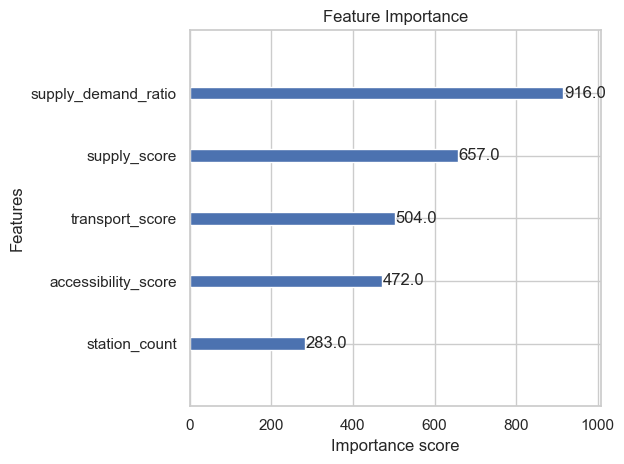

In [123]:
from modeling.xgboost_model import train_and_predict

# üîç ÏÑ±Îä• Ìñ•ÏÉÅÏùÑ ÏúÑÌïú feature ÌôïÏû•
selected_features = [
    'supply_score', 'station_count', 'commercial_count',
    'supply_demand_ratio', 'population_density',
    'accessibility_score', 'transport_score',
    'cluster'
]

# Í≤∞Ï∏°Ïπò Î°úÍ∑∏
valid_rows = features.dropna(subset=selected_features + ['demand_score'])
print(f"Í≤∞Ï∏°Ïπò Ï†úÍ±∞ ÌõÑ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ïàò: {len(valid_rows)}")

# XGBoost ÌïôÏäµ Î∞è ÏòàÏ∏°
features, metrics = train_and_predict(
    df=features,
    features=selected_features,
    label='demand_score',                # ‚Üê Í∏∞Ï°¥ target_column -> labelÎ°ú Î∞îÎÄú
    n_estimators=XGB_N_ESTIMATORS,
    verbose=True                         # ‚Üê ÏÑ±Îä• ÏßÄÌëúÏôÄ Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî Î≥¥Í∏∞
)

# ÏòàÏ∏° Í≤∞Í≥º Ï°¥Ïû¨ Ïó¨Î∂Ä ÌôïÏù∏
assert 'predicted_demand_score' in features.columns, "ÏòàÏ∏° Í≤∞Í≥º ÏπºÎüº ÎàÑÎùΩ"

# Ï†ÄÏû•
features.to_csv(f"{DATA_DIR}/grid_features_with_prediction.csv", index=False)
pd.DataFrame([metrics]).to_csv(f"{OUTPUT_DIR}/xgboost_metrics.csv", index=False)


# MCLP

In [136]:
from modeling.mclp_model import run_sensitivity_analysis

sensitivity_df = run_sensitivity_analysis(
    df=features,
    coverage_radii_km=[COVERAGE_RADIUS * 111],  # ÌòÑÏû¨ Î∞òÍ≤Ω 0.005 degree ‚âí ÏïΩ 0.55km
    facility_limits = list(range(20, 101, 10)), # 50Í∞ú ~ 100Í∞úÍπåÏßÄ 10 Îã®ÏúÑÎ°ú Ïã§Ìóò
    demand_column='predicted_demand_score',
    verbose=True
)

# ‚úÖ Ï¥ù Ïª§Î≤Ñ ÏàòÏöîÍ∞Ä Í∞ÄÏû• ÌÅ∞ Ï°∞Ìï©ÏùÑ ÏÑ†ÌÉù
best_row = sensitivity_df.loc[sensitivity_df['covered_demand'].idxmax()]

best_radius = best_row['coverage_radius_km']
best_limit = best_row['facility_limit']

print(f"\nüìå ÏµúÏ†Å Î∞òÍ≤Ω: {best_radius}km")
print(f"üìå ÏµúÏ†Å ÏÑ§Ïπò Ïàò: {best_limit}Í∞ú (ÏÑ§Ïπò Ìö®Ïú®: {best_row['installation_efficiency']})")



üìå Î∞òÍ≤Ω 0.555km, ÏÑ§Ïπò 20Í∞ú ÏãúÎÇòÎ¶¨Ïò§ Ïã§Ìñâ Ï§ë...


üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26618.29it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/1aecdaae47e5472a9ba63c5d2be95f76-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/1aecdaae47e5472a9ba63c5d2be95f76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 206375 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 46 integers unsatisfied sum - 15.2667
Cbc0038I Pass   1: suminf.    1.33333 (4) obj. -197699 iteratio

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26884.60it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/269fbd0d355742798795810ac36438fa-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/269fbd0d355742798795810ac36438fa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 275612 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 51 integers unsatisfied sum - 13.8182
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -270146 iteratio

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26692.36it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/e8700f3dc5724ba6a5dce85cbbb11d47-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/e8700f3dc5724ba6a5dce85cbbb11d47-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 332162 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 54 integers unsatisfied sum - 12.4667
Cbc0038I Pass   1: suminf.    3.66667 (11) obj. -327549 iterati

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 25805.67it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/8e69b78c5e03411fb04367d477811128-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/8e69b78c5e03411fb04367d477811128-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 381146 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 101 integers unsatisfied sum - 29.4167
Cbc0038I Pass   1: suminf.    5.66667 (19) obj. -373429 iterat

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26390.95it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/74e2066afe5b4513946f4c8cbd2f10b8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/74e2066afe5b4513946f4c8cbd2f10b8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 425247 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 124 integers unsatisfied sum - 37.6818
Cbc0038I Pass   1: suminf.    4.00000 (12) obj. -419097 iterat

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26239.65it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/f6f83944808f4809adcac240531cf2dc-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/f6f83944808f4809adcac240531cf2dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 464593 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 107 integers unsatisfied sum - 32.9545
Cbc0038I Pass   1: suminf.    4.00000 (12) obj. -456941 iterat

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26121.29it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/06cae7600dca41a2b33641fbf7b3177b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/06cae7600dca41a2b33641fbf7b3177b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 500222 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 127 integers unsatisfied sum - 40.1178
Cbc0038I Pass   1: suminf.   15.63333 (45) obj. -490666 iterat

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26409.90it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/3d41626794ac40aa802a62832a9de323-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/3d41626794ac40aa802a62832a9de323-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 532154 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 128 integers unsatisfied sum - 36.1908
Cbc0038I Pass   1: suminf.    6.33333 (19) obj. -522971 iterat

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 26691.07it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/59e3720fff164349ba54939b1f456c43-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/59e3720fff164349ba54939b1f456c43-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 560418 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 142 integers unsatisfied sum - 44.2752
Cbc0038I Pass   1: suminf.    8.55556 (25) obj. -554438 iterat

In [138]:
# delta Í≥ÑÏÇ∞
sensitivity_df['delta_demand'] = sensitivity_df['covered_demand'].diff()
sensitivity_df['delta_ratio'] = sensitivity_df['delta_demand'] / sensitivity_df['facility_limit'].diff()

# ÏµúÎåÄ Ï¶ùÍ∞ÄÏú® Í∏∞Ï§ÄÏúºÎ°ú threshold ÏÑ§Ï†ï
max_delta_ratio = sensitivity_df['delta_ratio'].max()
threshold = max_delta_ratio * 0.6

# Ï°∞Í±¥Ïóê ÎßûÎäî ÏßÄÏ†ê ÌÉêÏÉâ
elbow_candidates = sensitivity_df[sensitivity_df['delta_ratio'] < threshold]

if not elbow_candidates.empty:
    elbow_point = elbow_candidates.iloc[0]
    print("üìç Í∫æÏù¥Îäî ÏßÄÏ†ê (Ìö®Ïú® Í∏âÍ∞ê ÏãúÏûë):")
    print(elbow_point[['facility_limit', 'covered_demand', 'delta_demand', 'delta_ratio']])
else:
    print("‚ö†Ô∏è Ï¶ùÍ∞ÄÏú®Ïù¥ threshold Ïù¥ÌïòÎ°ú Îñ®Ïñ¥ÏßÄÎäî ÏßÄÏ†êÏù¥ ÏóÜÏäµÎãàÎã§.")


üìç Í∫æÏù¥Îäî ÏßÄÏ†ê (Ìö®Ïú® Í∏âÍ∞ê ÏãúÏûë):
facility_limit        60.000
covered_demand    101921.860
delta_demand        8601.030
delta_ratio          860.103
Name: 4, dtype: float64


In [ ]:
from modeling.mclp_model import solve_mclp

# Í∫æÏù¥Îäî ÏßÄÏ†ê Í∏∞Ï§ÄÏúºÎ°ú Ï†ÄÏû•
if not elbow_candidates.empty:
    elbow_point = elbow_candidates.iloc[0]
    optimal_limit = int(elbow_point['facility_limit'])

    # MCLP Îã§Ïãú Ïã§Ìñâ (Ìï¥Îãπ ÏµúÏ†Å ÏÑ§Ïπò Ïàò Í∏∞Ï§Ä)
    final_result = solve_mclp(
        df=features,
        coverage_radius=COVERAGE_RADIUS,
        facility_limit=optimal_limit,
        demand_column='predicted_demand_score',
        verbose=True
    )
    
    # ÌååÏùºÎ™ÖÏóê ÏµúÏ†Å ÏÑ§Ïπò Ïàò Ìè¨Ìï®ÌïòÏó¨ Ï†ÄÏû•
    final_result.to_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv", index=False)

    print(f"\n‚úÖ Í∫æÏù¥Îäî ÏßÄÏ†ê Í∏∞Ï§Ä Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å:")
    
    # ÏÑ§Ïπò ÏúÑÏπò ÌôïÏù∏
    selected = final_result[final_result['selected'] == 1]
    print(f"ÏÑ§Ïπò ÎåÄÏÉÅÏßÄ Ïàò: {len(selected)}")
    print(f"Ïª§Î≤Ñ ÏàòÏöî Ï¥ùÌï©: {selected['predicted_demand_score'].sum():,.2f}")
else:
    print("‚ö†Ô∏è Ï†ÄÏû•Ìï† Í∫æÏù¥Îäî ÏßÄÏ†êÏù¥ ÏóÜÏñ¥ ÌååÏùº Ï†ÄÏû•ÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")

üß© Ï†úÏïΩÏ°∞Í±¥ ÏÉùÏÑ± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 526/526 [00:00<00:00, 25504.36it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/abef2918706d4d9c8485ae42341cd38c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/abef2918706d4d9c8485ae42341cd38c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 425247 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 124 integers unsatisfied sum - 37.6818
Cbc0038I Pass   1: suminf.    4.00000 (12) obj. -419097 iterat

# ÌèâÍ∞Ä

In [153]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏàòÎ•º 60ÏúºÎ°ú ÏÑ§Ï†ïÌïòÍ≥† Ïû¨ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
from modeling.kmeans_model import run_kmeans

grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")
grid = run_kmeans(
    grid,
    mode='manual',
    manual_k=60,  # ‚úÖ ÏàòÎèôÏúºÎ°ú 60Í∞ú ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏßÄÏ†ï
    return_top_cluster_only=False
)

# Î≥ëÌï©
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]
# Î≥ëÌï©
features = features_all.merge(grid, on='grid_id', how='inner')

# center_lat/center_lon Ïª¨Îüº Ï†ïÎ¶¨
features = features.rename(columns={
    'center_lat_x': 'center_lat',
    'center_lon_x': 'center_lon'
}) if 'center_lat_x' in features.columns else features

features = features.rename(columns={
    'center_lat_y': 'center_lat',
    'center_lon_y': 'center_lon'
}) if 'center_lat_y' in features.columns else features

features['cluster'] = features['cluster'].astype(int)

# ÌèâÍ∞Ä (ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨ ÏÑ§Ïπò: 60Í∞ú ÏÑ§Ïπò)
baseline3 = evaluate_cluster_centers(features)

#==============

features = pd.read_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv")

# ‚úÖ Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå Îç∞Ïù¥ÌÑ∞ Î≥ÄÍ≤Ω
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")

# üìä ÌèâÍ∞Ä Ïã§Ìñâ
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='ÏúÑÎèÑ',
    lon_col='Í≤ΩÎèÑ'
)
baseline2 = evaluate_random_installation(features, n=FACILITY_LIMIT)
#baseline3 = evaluate_cluster_centers(features)
actual_facility_count = features['selected'].sum()

baseline4 = evaluate_mclp_result(
    df=features,
    facility_limit=actual_facility_count  # üîÅ Ïó¨Í∏∞Î•º Ïã§Ï†ú ÏÑ§Ïπò ÏàòÎ°ú!
)

[MANUAL MODE] ÏàòÎèô ÏÑ§Ï†ï k = 60

[ClusterÎ≥Ñ ÌèâÍ∑† ÏàòÏöî]
cluster
2     4902.500000
30    4120.500000
12    3662.166667
34    3315.200000
8     3125.200000
52    2952.000000
29    2749.708333
3     2529.055556
26    2312.468750
13    2055.333333
47    1993.111111
33    1845.800000
5     1680.520833
58    1581.000000
37    1531.250000
22    1442.906250
11    1368.804348
48    1319.307692
19    1226.066667
38    1171.233333
42    1121.709677
1     1032.028571
21    1002.804348
46     920.912500
53     884.156250
18     791.472727
54     776.340909
31     740.014286
32     685.545455
4      645.388889
49     626.140000
51     606.750000
9      597.310811
55     526.920000
35     524.065217
44     509.817308
14     492.352941
20     415.756098
16     400.677778
59     363.578431
36     305.327586
25     298.737500
40     283.018519
57     254.964286
6      227.238462
28     186.112903
27     153.766667
24     108.284091
45     106.882353
41      89.570175
15      71.361702
39      38.

/Users/masterj/Documents/GitHub/2025-1-Big-Data-Programming/src/evaluation/baseline_evaluator.py:100: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  nearest = group.loc[dists.idxmin(), 'grid_id']


KeyError: "None of [Index([nan, nan, nan, nan], dtype='float64')] are in the [index]"

In [150]:
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# üîÅ Í∏∞Ï§Ä Îç∞Ïù¥ÌÑ∞
features = pd.read_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv")
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
optimal_facility_count = int(features['selected'].sum())  # ÌòÑÏû¨ 60Í∞ú

# üìä ÌèâÍ∞Ä Ïã§Ìñâ
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='ÏúÑÎèÑ',
    lon_col='Í≤ΩÎèÑ'
)

baseline2 = evaluate_random_installation(features, n=optimal_facility_count)

baseline3 = evaluate_cluster_centers(features, n=optimal_facility_count)

baseline4 = evaluate_mclp_result(df=features, facility_limit=optimal_facility_count)

[Baseline ‚ë† Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå Í∏∞Ï§Ä]
- ÏÑ§Ïπò Í≤©Ïûê Ïàò: 523
- Ïª§Î≤Ñ ÏàòÏöî: 712,847.65
- Ï†ÑÏ≤¥ ÏàòÏöî: 716,087.70
- Ïª§Î≤ÑÏú®: 99.55%
[Baseline ‚ë° ÎûúÎç§ ÏÑ§Ïπò]
- ÏÑ§Ïπò Í≤©Ïûê Ïàò: 60
- Ïª§Î≤Ñ ÏàòÏöî: 78,115.31
- Ï†ÑÏ≤¥ ÏàòÏöî: 716,087.70
- Ïª§Î≤ÑÏú®: 10.91%


TypeError: evaluate_cluster_centers() got an unexpected keyword argument 'n'

In [24]:
results = pd.DataFrame([
    {'baseline': '‚ë† Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå', **baseline1},
    {'baseline': '‚ë° ÎûúÎç§ ÏÑ§Ïπò', **baseline2},
    {'baseline': '‚ë¢ ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨', **baseline3},
    {'baseline': '‚ë£ MCLP ÏµúÏ†ÅÌôî', **baseline4}
])

from IPython.display import display
display(results)

baseline       coverage  coverage_rate  covered_grids          dsr  \
0    ‚ë† Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå  712847.646545      99.547534          523.0          NaN   
1     ‚ë° ÎûúÎç§ ÏÑ§Ïπò   38727.618958       5.408223           30.0          NaN   
2   ‚ë¢ ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨     797.631165       0.111387            1.0          NaN   
3  ‚ë£ MCLP ÏµúÏ†ÅÌôî   63445.195374       8.859976            NaN  2114.839846   

    efficiency  selected   total_demand  
0          NaN       NaN            NaN  
1          NaN       NaN            NaN  
2          NaN       NaN            NaN  
3  2114.839846      30.0  716087.700928

/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1131/1391480480.py:21: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


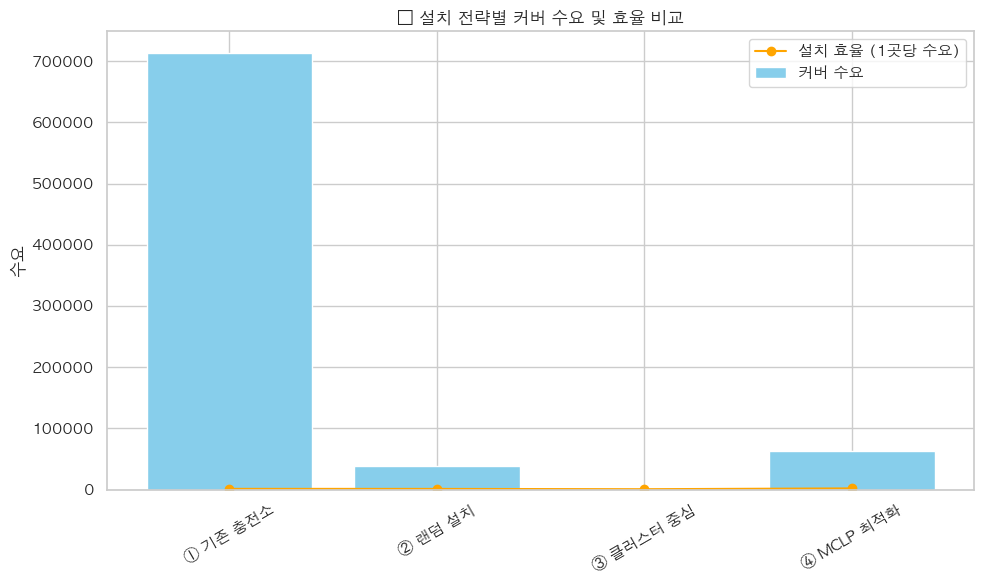

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# ‚úÖ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (OSÏóê ÎßûÍ≤å ÏÑ†ÌÉù)
mpl.rcParams['font.family'] = 'AppleGothic'  # macOS
# mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows
mpl.rcParams['axes.unicode_minus'] = False

df = results.copy()
df['selected'] = df['selected'].fillna(df['covered_grids'])

plt.figure(figsize=(10, 6))
plt.bar(df['baseline'], df['coverage'], color='skyblue', label='Ïª§Î≤Ñ ÏàòÏöî')
plt.plot(df['baseline'], df['coverage'] / df['selected'], color='orange', marker='o', label='ÏÑ§Ïπò Ìö®Ïú® (1Í≥≥Îãπ ÏàòÏöî)')

plt.xticks(rotation=30)
plt.ylabel("ÏàòÏöî")
plt.title("‚ö° ÏÑ§Ïπò Ï†ÑÎûµÎ≥Ñ Ïª§Î≤Ñ ÏàòÏöî Î∞è Ìö®Ïú® ÎπÑÍµê")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
import folium
from geopy.distance import geodesic
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0):
    """
    Ïó¨Îü¨ ÏÑ§Ïπò Ï†ÑÎûµÏùÑ Ìïú ÏßÄÎèÑÏóê Í≤©Ïûê Ïª§Î≤ÑÎ¶¨ÏßÄÎ•º ÏÉâÏÉÅÎ≥ÑÎ°ú Íµ¨Î∂ÑÌïòÏó¨ ÏãúÍ∞ÅÌôî

    Parameters:
    - features: Ï†ÑÏ≤¥ grid DataFrame (center_lat, center_lon Ìè¨Ìï®)
    - strategy_dict: {label: ÏÑ§ÏπòÏßÄ DataFrame} ÌòïÏãù
    - radius_km: Ïª§Î≤Ñ Î∞òÍ≤Ω
    """
    # ÏßÄÎèÑ Ï¥àÍ∏∞Ìôî (ÏÑúÏö∏ Ï§ëÏã¨)
    m = folium.Map(location=[37.55, 126.98], zoom_start=11, tiles='cartodbpositron')

    # Í≥†Ïú† ÏÉâÏÉÅ ÏÑ§Ï†ï
    color_map = {
        '‚ë† Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå': 'red',
        '‚ë° ÎûúÎç§ ÏÑ§Ïπò': 'green',
        '‚ë¢ ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨': 'purple',
        '‚ë£ MCLP ÏµúÏ†ÅÌôî': 'blue'
    }

    for label, install_df in strategy_dict.items():
        color = color_map[label]

        for _, grid in features.iterrows():
            grid_center = (grid['center_lat'], grid['center_lon'])
            for _, site in install_df.iterrows():
                site_center = (site['center_lat'], site['center_lon'])
                if geodesic(grid_center, site_center).km <= radius_km:
                    folium.CircleMarker(
                        location=grid_center,
                        radius=2.5,
                        color=color,
                        fill=True,
                        fill_opacity=0.3,
                        popup=f"{label} Ïª§Î≤Ñ"
                    ).add_to(m)
                    break

        # ÏÑ§Ïπò ÏúÑÏπò Í∞ïÏ°∞
        for _, site in install_df.iterrows():
            folium.Marker(
                location=(site['center_lat'], site['center_lon']),
                icon=folium.Icon(color=color, icon='bolt', prefix='fa'),
                popup=f"{label} ÏÑ§ÏπòÏßÄ"
            ).add_to(m)

    return m

In [ ]:
# Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå
existing_stations_df = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
existing_stations_df = existing_stations_df.dropna(subset=['ÏúÑÎèÑ', 'Í≤ΩÎèÑ']).copy()
existing_stations_df = existing_stations_df.rename(columns={'ÏúÑÎèÑ': 'center_lat', 'Í≤ΩÎèÑ': 'center_lon'})

# MCLP ÏÑ§ÏπòÏßÄ
mclp_selected_df = features[features['selected'] == 1][['grid_id', 'center_lat', 'center_lon']].copy()

# ÎûúÎç§ ÏÑ§Ïπò
np.random.seed(42)
random_sites_df = features.sample(n=FACILITY_LIMIT)[['grid_id', 'center_lat', 'center_lon']].copy()

# ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨ (Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßàÎã§ Ï§ëÏã¨ 1Í∞úÏî©)
cluster_center_df = features.groupby('cluster')[['center_lat', 'center_lon']].mean().reset_index()

# Ï†ÑÎûµÎ≥Ñ dict
strategy_dict = {
    "‚ë† Í∏∞Ï°¥ Ï∂©Ï†ÑÏÜå": existing_stations_df,
    "‚ë° ÎûúÎç§ ÏÑ§Ïπò": random_sites_df,
    "‚ë¢ ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨": cluster_center_df,
    "‚ë£ MCLP ÏµúÏ†ÅÌôî": mclp_selected_df
}

# ÏßÄÎèÑ ÏÉùÏÑ± Î∞è Ï†ÄÏû•
map_all = plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0)
map_all.save("../outputs/maps/coverage_comparison_map.html")
map_all